# Brain Tumor Detection and 3D Reconstruction
## Overview:
### Database Used: 
Bakas S, Akbari H, Sotiras A, Bilello M, Rozycki M, Kirby J, Freymann J, Farahani K, Davatzikos C. (2017) Segmentation Labels and Radiomic Features for the Pre-operative Scans of the TCGA-LGG collection [Data Set]. The Cancer Imaging Archive. DOI:  10.7937/K9/TCIA.2017.GJQ7R0EF
### Author
This project was completed by Tiffany Nguyen for her BIOE 45 final project

# Part 1: 3D Reconstruction of Brain MRI Scans
## Purpose: 
The purpose of this portion of the project is to take MRI scans and create a 3D reconstruction of both the brain and the labeled tumor to give the viewer more spatial awareness so they can get a better sense of what the tumor looks like in 3D space

## Step 1: Visualing First Scan
The databased provides MRI scans in various formats (T1, T1-Gd, T2, T2-FLAIR), so this section is used to view slices of the first scan in different formats side-by-side. In future steps, however, T2 will be used as it highlights both fat and water and is therefore best at detecting abnormalities.

In [91]:
import nibabel as nib
import cv2
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
import scipy.misc

In [92]:
#File names
folder_path = "/Users/tiffanynguyen/Downloads/tagged/SCU/BIOE 45/Final Project/PKG - BraTS-TCGA-LGG/BraTS-TCGA-LGG/Pre-operative_TCGA_LGG_NIfTI_and_Segmentations/TCGA-CS-4942/"
flair = "TCGA-CS-4942_1997.02.22_flair.nii.gz"
gb_manually_corrected = "TCGA-CS-4942_1997.02.22_GlistrBoost_ManuallyCorrected.nii.gz"
glistr_boost = "TCGA-CS-4942_1997.02.22_GlistrBoost.nii.gz"
t1 = "TCGA-CS-4942_1997.02.22_t1.nii.gz"
t1_gd = "TCGA-CS-4942_1997.02.22_t1Gd.nii.gz"
t2 = "TCGA-CS-4942_1997.02.22_t2.nii.gz"

#Load files 
flair_img = nib.load(folder_path + flair).get_fdata()
gb_manually_corrected_img = nib.load(folder_path + gb_manually_corrected).get_fdata()
glistr_boost_img = nib.load(folder_path + glistr_boost).get_fdata()
t1_img = nib.load(folder_path + t1).get_fdata()
t1_gd_img = nib.load(folder_path + t1_gd).get_fdata()
t2_img = nib.load(folder_path + t2).get_fdata()

In [93]:
@widgets.interact(axial_slice=(0, flair_img.shape[2]-1))
def axial_slicer(axial_slice=0):
    plt.subplot(2, 3, 1).set_title("Flair")
    plt.imshow(flair_img[:, :, axial_slice], cmap="gray")
    plt.subplot(2, 3, 2).set_title("GB Manually Corrected")
    plt.imshow(gb_manually_corrected_img[:, :, axial_slice], cmap="gray")
    plt.subplot(2, 3, 3).set_title("Glistr Boost")
    plt.imshow(glistr_boost_img[:, :, axial_slice], cmap="gray")
    plt.subplot(2, 3, 4).set_title("T1")
    plt.imshow(t1_img[:, :, axial_slice], cmap="gray")
    plt.subplot(2, 3, 5).set_title("T1 w/ GB")
    plt.imshow(t1_gd_img[:, :, axial_slice], cmap="gray")
    plt.subplot(2, 3, 6).set_title("T2")
    plt.imshow(t2_img[:, :, axial_slice], cmap="gray")
    
    plt.suptitle("Scan Files")
    plt.subplots_adjust(wspace=0.4, hspace=0.2)
    plt.show()

interactive(children=(IntSlider(value=0, description='axial_slice', max=154), Output()), _dom_classes=('widget…

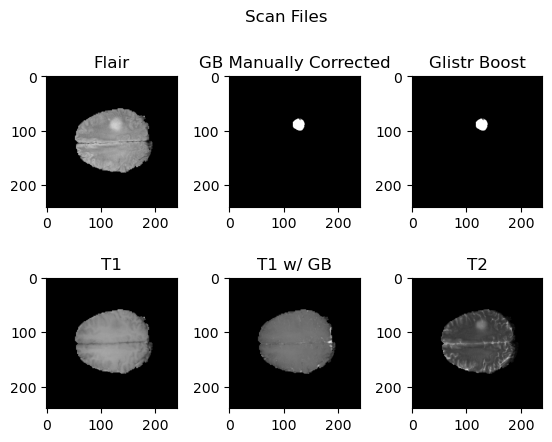

In [94]:
# Show single slice without widget
axial_slice = 100

plt.subplot(2, 3, 1).set_title("Flair")
plt.imshow(flair_img[:, :, axial_slice], cmap="gray")
plt.subplot(2, 3, 2).set_title("GB Manually Corrected")
plt.imshow(gb_manually_corrected_img[:, :, axial_slice], cmap="gray")
plt.subplot(2, 3, 3).set_title("Glistr Boost")
plt.imshow(glistr_boost_img[:, :, axial_slice], cmap="gray")
plt.subplot(2, 3, 4).set_title("T1")
plt.imshow(t1_img[:, :, axial_slice], cmap="gray")
plt.subplot(2, 3, 5).set_title("T1 w/ GB")
plt.imshow(t1_gd_img[:, :, axial_slice], cmap="gray")
plt.subplot(2, 3, 6).set_title("T2")
plt.imshow(t2_img[:, :, axial_slice], cmap="gray")

plt.suptitle("Scan Files")
plt.subplots_adjust(wspace=0.4, hspace=0.2)
plt.show()

## Step 2: Edge Detection
To create a 3D reconstruction of the brain, I will first detect the edges of the brain so that the final graph will create a "hollow" brain with just a mesh plot of the edge.

In [95]:
import sys

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import cm

import numpy
from numpy.random import randn

from scipy import array, newaxis
from scipy.ndimage import zoom

from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from mpl_toolkits.mplot3d import Axes3D

from skimage import feature

In [96]:
# Preprocessing: resize T2 image (so it doesn't exceed max size when creating mesh later on)
scale = 0.4
t2_img_resized = zoom(t2_img, (scale, scale, scale)) 

### 2.1 Comparison of Different Strategies
While doing research, I came across several pre-existing libraries and methods for edge detection, so this section aims to provide a comparision between the different methods for edge detection by showing the detected edges overlaid over the original image. In future steps, the contour strategy will be used since the other methods often detect edges within the brain as well, which made the 3D mesh of the final brain more cluttered.

Notes:
- For Skimage Canny Edges, `ksize` is set to 3 and `sigma` is set to 3
- A slider is provided to change the treshold values for CV2's canny edges

In [71]:
# Constants for Skimage Canny Edges
ksize = 3
sigma = 3

@widgets.interact(axial_slice=(0, t2_img_resized.shape[2]-1), threshold_1_val=(0, 255), threshold_2_val=(0, 255))
def axial_slicer(axial_slice=0, threshold_1_val=0, threshold_2_val=255):
    image = t2_img_resized[:, :, axial_slice]
    
    # CV2 CANNY EDGES
    # Preprocessing
    img_normalize = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX) # Normalize Image
    img_blur = cv2.GaussianBlur(img_normalize, (3,3), 0) #blur image
    img_unit8 = np.uint8(img_blur) #fix format for cv2
    
    # Canny Edge Detection
    cv2_canny_edges = cv2.Canny(image=img_unit8, threshold1=threshold_1_val, threshold2=threshold_2_val)

    # display results
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(8, 3))
    ax[0].imshow(image, cmap='gray')
    ax[0].imshow(cv2_canny_edges, cmap='gray',  alpha=1.0*(cv2_canny_edges>0))
    ax[0].set_title('CV2 \n Canny Edges', fontsize=16)
    
    # CV2 CONTOUR
    # Threshold
    thresh = cv2.threshold(img_unit8, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
    
    # Get contours and filter out small defects
    contour_edges = np.zeros_like(img_unit8)
    contours = cv2.findContours(thresh , cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]
    for cntr in contours:
        area = cv2.contourArea(cntr)
        if area > 20:
            cv2.drawContours(contour_edges, [cntr], 0, 255, 1)
        
    # Show image
    ax[1].imshow(image, cmap='gray')
    ax[1].imshow(contour_edges, cmap='gray', alpha=1.0*(contour_edges>0))
    ax[1].set_title('CV2 \n Contour', fontsize=16)
    
    # SKIMAGE CANNY EDGES
    # Compute the Canny filter for two values of sigma
    skimage_canny_edges = feature.canny(image, sigma=3, low_threshold=0, high_threshold=75)

    ax[2].imshow(image, cmap='gray')
    ax[2].imshow(skimage_canny_edges, cmap='gray',  alpha=1.0*(skimage_canny_edges>0))
    ax[2].set_title('Skimage \n Canny Edges', fontsize=16)

    for a in ax:
        a.axis('off')

    fig.tight_layout()
    plt.show()


interactive(children=(IntSlider(value=0, description='axial_slice', max=61), IntSlider(value=0, description='t…

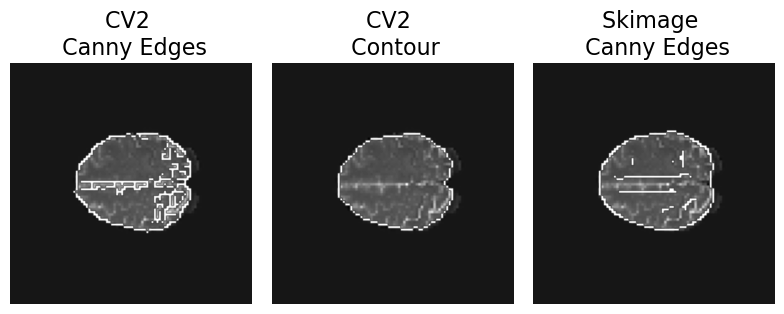

In [98]:
# Show without widget (otherwise, same code as above)
axial_slice=44
threshold_1_val=0
threshold_2_val=255

image = t2_img_resized[:, :, axial_slice]
    
# CV2 CANNY EDGES
# Preprocessing
img_normalize = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX) # Normalize Image
img_blur = cv2.GaussianBlur(img_normalize, (3,3), 0) #blur image
img_unit8 = np.uint8(img_blur) #fix format for cv2

# Canny Edge Detection
cv2_canny_edges = cv2.Canny(image=img_unit8, threshold1=threshold_1_val, threshold2=threshold_2_val)

# display results
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(8, 3))
ax[0].imshow(image, cmap='gray')
ax[0].imshow(cv2_canny_edges, cmap='gray',  alpha=1.0*(cv2_canny_edges>0))
ax[0].set_title('CV2 \n Canny Edges', fontsize=16)

# CV2 CONTOUR
# Threshold
thresh = cv2.threshold(img_unit8, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]

# Get contours and filter out small defects
contour_edges = np.zeros_like(img_unit8)
contours = cv2.findContours(thresh , cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
contours = contours[0] if len(contours) == 2 else contours[1]
for cntr in contours:
    area = cv2.contourArea(cntr)
    if area > 20:
        cv2.drawContours(contour_edges, [cntr], 0, 255, 1)

# Show image
ax[1].imshow(image, cmap='gray')
ax[1].imshow(contour_edges, cmap='gray', alpha=1.0*(contour_edges>0))
ax[1].set_title('CV2 \n Contour', fontsize=16)

# SKIMAGE CANNY EDGES
# Compute the Canny filter for two values of sigma
skimage_canny_edges = feature.canny(image, sigma=3, low_threshold=0, high_threshold=75)

ax[2].imshow(image, cmap='gray')
ax[2].imshow(skimage_canny_edges, cmap='gray',  alpha=1.0*(skimage_canny_edges>0))
ax[2].set_title('Skimage \n Canny Edges', fontsize=16)

for a in ax:
    a.axis('off')

fig.tight_layout()
plt.show()

### 2.2 Performing Edge Detection on All Slices

In [99]:
edges_3d = np.zeros(shape=(t2_img_resized.shape[0], t2_img_resized.shape[1], t2_img_resized.shape[2])) #numpy array to store all edges

for cur_slice in range (t2_img_resized.shape[2]):
    img_normalize = cv2.normalize(t2_img_resized[:, :, cur_slice], None, 0, 255, cv2.NORM_MINMAX)
    img_unit8 = np.uint8(img_normalize)
    
    # threshold
    thresh = cv2.threshold(img_unit8, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
    
    # get contours and filter out small defects
    cur_edge = np.zeros_like(img_unit8)
    contours = cv2.findContours(thresh , cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]
    for cntr in contours:
        area = cv2.contourArea(cntr)
        if area > 20:
            cv2.drawContours(cur_edge, [cntr], 0, 255, 1)

    # iterate through pixels and store in 3D numpy array
    # don't includes edges since that is highlighted when nothing is in frame)
    for i in range (1, cur_edge.shape[0]-5):
        for j in range (1, cur_edge.shape[0]-5):
            edges_3d[i][j][cur_slice]=cur_edge[i][j]

## Step 3: Graph Mesh Plot of Edge

In [100]:
from skimage import measure

In [101]:
# Use marching cubes to obtain the surface mesh
brain_verts, brain_faces, normals, values = measure.marching_cubes(edges_3d, 0)    

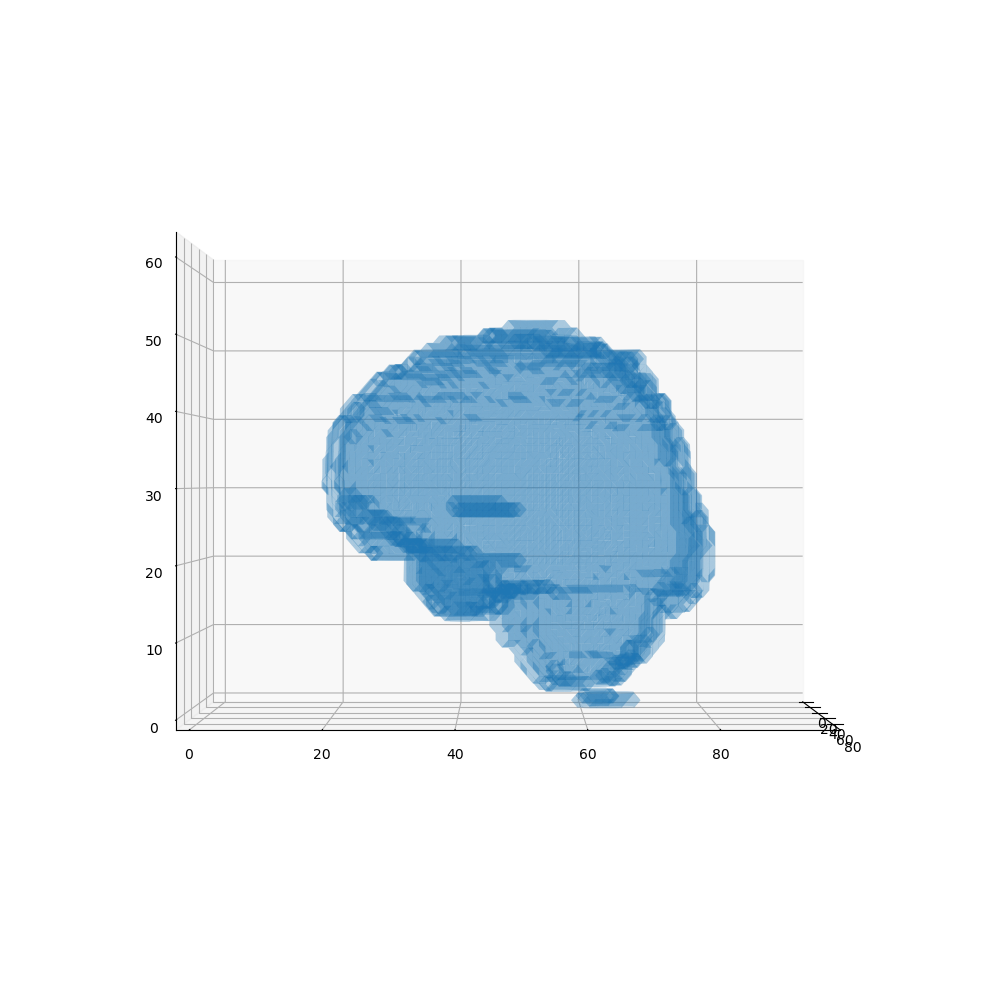

In [102]:
# Visualize slice
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Fancy indexing: `verts[faces]` to generate a collection of triangles
mesh = Poly3DCollection(brain_verts[brain_faces], alpha=0.2)
# mesh.set_edgecolor('k')
ax.add_collection3d(mesh)

ax.set_xlim(0, edges_3d.shape[0])
ax.set_ylim(0, edges_3d.shape[1])
ax.set_zlim(0, edges_3d.shape[2])

ax.view_init(elev=0, azim=0, roll=0)

plt.tight_layout()
plt.show()

In [104]:
# Include widget to change angle of graph
@widgets.interact(azim_angle = (0, 360)) 
def plot_mesh(azim_angle=0):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    mesh = Poly3DCollection(brain_verts[brain_faces], alpha=0.2)
    ax.add_collection3d(mesh)


    ax.set_xlim(0, edges_3d.shape[0])
    ax.set_ylim(0, edges_3d.shape[1])
    ax.set_zlim(0, edges_3d.shape[2])

    ax.view_init(elev=0, azim=azim_angle, roll=0)

    plt.tight_layout()
    plt.show()

interactive(children=(IntSlider(value=0, description='azim_angle', max=360), Output()), _dom_classes=('widget-…

## Step 4: Repeat Edge Detection and Mesh Plotting for Segment

### 4.1 Edge Detection Visualization

In [107]:
gb_manually_corrected_img_resized = zoom(gb_manually_corrected_img, (scale, scale, scale)) #resize image
@widgets.interact(axial_slice=(0, gb_manually_corrected_img_resized.shape[2]-1))
def axial_slicer(axial_slice=0):
    # normalize image
    img_normalize = cv2.normalize(gb_manually_corrected_img_resized[:, :, axial_slice], None, 0, 255, cv2.NORM_MINMAX)
    img_unit8 = np.uint8(img_normalize)
    
    # threshold
    thresh = cv2.threshold(img_unit8, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
    
    # get contours and filter out small defects
    result = np.zeros_like(img_unit8)
    contours = cv2.findContours(thresh , cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]
    for cntr in contours:
        area = cv2.contourArea(cntr)
        if area > 20:
            cv2.drawContours(result, [cntr], 0, 255, 1)
        
    # Show image
    plt.figure()
    plt.imshow(gb_manually_corrected_img_resized[:, :, axial_slice], cmap="gray")
    plt.imshow(result, cmap="gray",  alpha=1.0*(result>0))
    plt.title("T2 Edge Detection Contour")
    plt.show()

interactive(children=(IntSlider(value=0, description='axial_slice', max=61), Output()), _dom_classes=('widget-…

### 4.2 Edge Detection for All Slices

In [108]:
seg_edges_3d = np.zeros(shape=(gb_manually_corrected_img_resized.shape[0], gb_manually_corrected_img_resized.shape[1], gb_manually_corrected_img_resized.shape[2]))

for cur_slice in range (gb_manually_corrected_img_resized.shape[2]):
    img_normalize = cv2.normalize(gb_manually_corrected_img_resized[:, :, cur_slice], None, 0, 255, cv2.NORM_MINMAX)
    img_unit8 = np.uint8(img_normalize)
    
    # threshold
    thresh = cv2.threshold(img_unit8, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
    
    # get contours and filter out small defects
    result = np.zeros_like(img_unit8)
    contours = cv2.findContours(thresh , cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]
    for cntr in contours:
        area = cv2.contourArea(cntr)
        if area > 20:
            cv2.drawContours(result, [cntr], 0, 255, 1)

    # iterate through pixels and add non-zero ones to list
    for i in range (1, result.shape[0]-5):
        for j in range (1, result.shape[1]-5):
            seg_edges_3d[i][j][cur_slice]=result[i][j]
# print(edges_3d[:, :, 30])

### 4.3 Mesh Plot

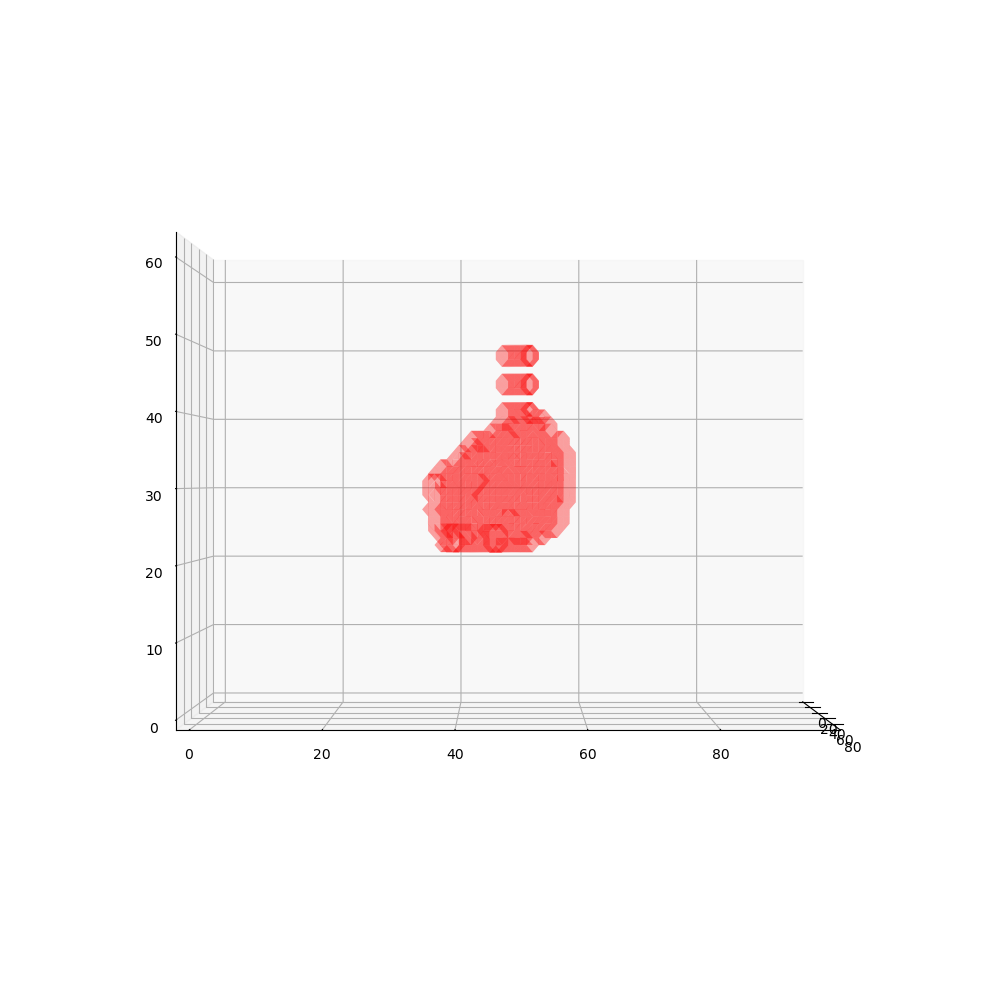

In [109]:
#Mesh plot
seg_verts, seg_faces, normals, values = measure.marching_cubes(seg_edges_3d, 0)    

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

mesh = Poly3DCollection(seg_verts[seg_faces], alpha=0.2)
mesh.set_facecolor('r')
ax.add_collection3d(mesh)

ax.set_xlim(0, seg_edges_3d.shape[0])
ax.set_ylim(0, seg_edges_3d.shape[1])
ax.set_zlim(0, seg_edges_3d.shape[2])

ax.view_init(elev=0, azim=0, roll=0)

plt.tight_layout()
plt.show()

## Step 5: Combine Brain and Tumor Meshes

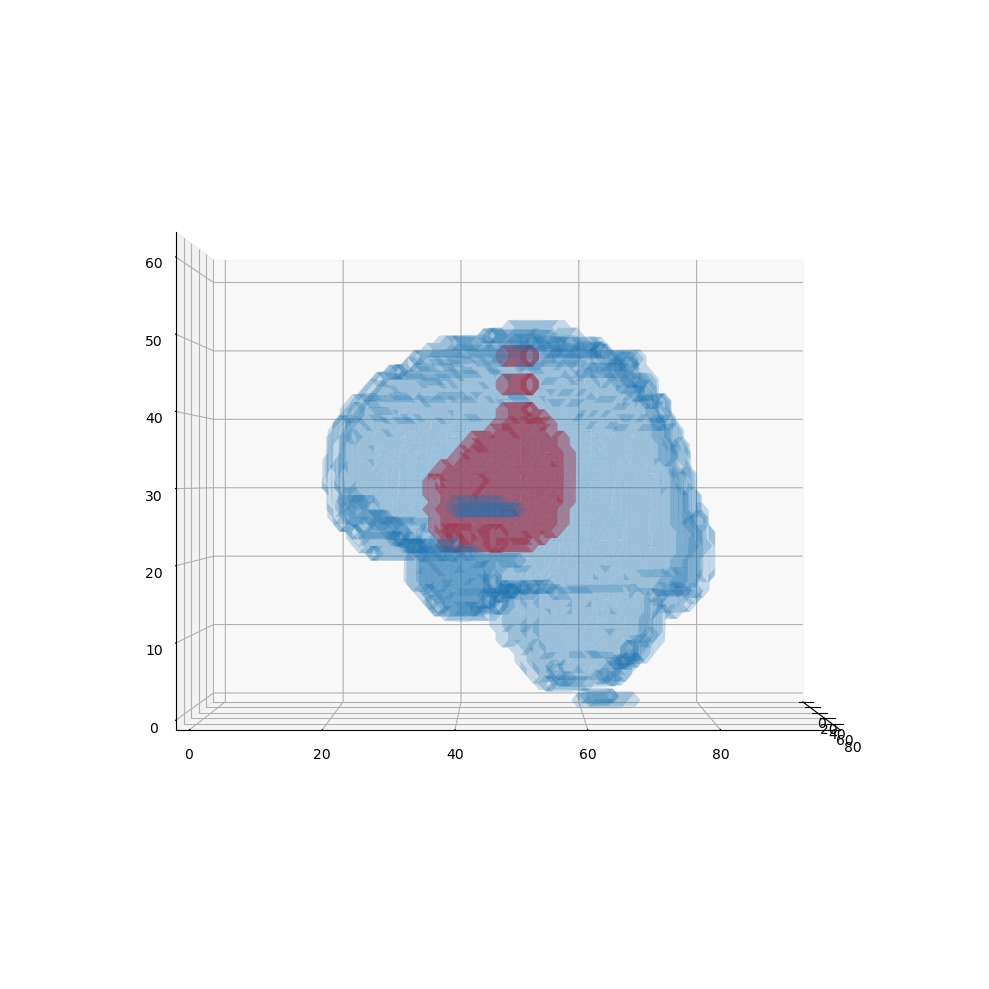

In [110]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Brain mesh
brain_mesh = Poly3DCollection(brain_verts[brain_faces], alpha=0.125)
ax.add_collection3d(brain_mesh)

# Segment mesh
seg_mesh = Poly3DCollection(seg_verts[seg_faces], alpha=0.25)
seg_mesh.set_facecolor('r')
ax.add_collection3d(seg_mesh)

ax.set_xlim(0, edges_3d.shape[0])
ax.set_ylim(0, edges_3d.shape[1])
ax.set_zlim(0, edges_3d.shape[2])

ax.view_init(elev=0, azim=0, roll=0)
plt.tight_layout()
plt.show()

In [111]:
# widget to change angle of graph
@widgets.interact(azim_angle = (0, 360)) 
def plot_mesh(azim_angle=0):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Brain mesh
    brain_mesh = Poly3DCollection(brain_verts[brain_faces], alpha=0.125)
    ax.add_collection3d(brain_mesh)
    
    # Segment mesh
    seg_mesh = Poly3DCollection(seg_verts[seg_faces], alpha=0.25)
    seg_mesh.set_facecolor('r')
    ax.add_collection3d(seg_mesh)

    ax.set_xlim(0, edges_3d.shape[0])
    ax.set_ylim(0, edges_3d.shape[1])
    ax.set_zlim(0, edges_3d.shape[2])

    ax.view_init(elev=0, azim=azim_angle, roll=0)
    plt.tight_layout()
    plt.show()

interactive(children=(IntSlider(value=0, description='azim_angle', max=360), Output()), _dom_classes=('widget-…

# Part 2: Detect Brain Tumor Using U-net CNN
## Purpose: 
The first part of this project created a 3D visualization of the tumor using pre-labeled segmentation of the tumor. In practice, however, MRI scans will not be labeled, so this portion of the project aims to provide assisstance by using a U-net CNN model to automatically perform image segmentation and separate the tumor from the rest of the scan.

## Step 1: Import all t2 and segmentation files

In [112]:
import os 
import glob

In [113]:
folder_path = '/Users/tiffanynguyen/Downloads/tagged/SCU/BIOE 45/Final Project/PKG - BraTS-TCGA-LGG/BraTS-TCGA-LGG/Pre-operative_TCGA_LGG_NIfTI_and_Segmentations'
mri_images_dir = os.listdir(folder_path) # get folders for the each scan
path_with_folder = [folder_path + '/' + cur_dir for cur_dir in mri_images_dir] #get complete path to each folder

# get all t2 files (name includes t2, make sure both t2 and segmentation file exist in the folder)
t2_files = [glob.glob(cur_path + '/*t2.nii.gz')[0] for cur_path in path_with_folder if glob.glob(cur_path + '/*t2.nii.gz') and glob.glob(cur_path + '/*GlistrBoost_ManuallyCorrected.nii.gz')]

#get all segmentation files
seg_files = [glob.glob(cur_path + '/*GlistrBoost_ManuallyCorrected.nii.gz')[0] for cur_path in path_with_folder if glob.glob(cur_path + '/*t2.nii.gz') and glob.glob(cur_path + '/*GlistrBoost_ManuallyCorrected.nii.gz')]

# print(t2_files)
# print(seg_files)
print("Num of t2 files:", len(t2_files))
print("Num of seg files:", len(seg_files))

Num of t2 files: 62
Num of seg files: 62


## Step 2: Get Image Slices
I will train the model on 2D images, but since the MRI data is 3D, I need to first extract and store each slice along the axial plane.

In [3]:
import nibabel as nib

In [4]:
# Get image slices of MRI data in axial plane
t2_images = list()
for cur_t2 in t2_files:
    cur_t2_img = nib.load(cur_t2).get_fdata()
    for cur_slice in range(cur_t2_img.shape[2]):
        t2_images.append(cur_t2_img[:, :, cur_slice])   

In [5]:
# Get image slices of segmentation data
seg_images = list()
for cur_seg_file in seg_files:
    cur_seg_img = nib.load(cur_seg_file).get_fdata()
    for cur_slice in range(cur_seg_img.shape[2]):
        seg_images.append(cur_seg_img[:, :, cur_slice])

In [6]:
import matplotlib.pyplot as plt
import ipywidgets as widgets

In [114]:
#Visualize all t2 slices and their corresponding segmentation file
@widgets.interact(cur_slice=(0, len(t2_images)-1))
def axial_slicer(cur_slice=0):    
    plt.subplot(1, 2, 1).set_title("T2 Image")
    plt.imshow(t2_images[cur_slice], cmap="gray")
    plt.subplot(1, 2, 2).set_title("GB Manually Corrected")
    plt.imshow(seg_images[cur_slice], cmap="gray")

interactive(children=(IntSlider(value=0, description='cur_slice', max=9609), Output()), _dom_classes=('widget-…

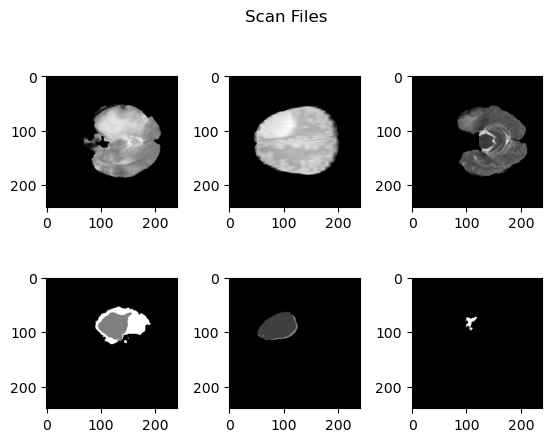

In [115]:
#Visualize random slice side by side
index1, index2, index3 = 676, 1347, 5160
plt.subplot(2, 3, 1)
plt.imshow(t2_images[index1], cmap="gray")
plt.subplot(2, 3, 2)
plt.imshow(t2_images[index2], cmap="gray")
plt.subplot(2, 3, 3)
plt.imshow(t2_images[index3], cmap="gray")
plt.subplot(2, 3, 4)
plt.imshow(seg_images[index1], cmap="gray")
plt.subplot(2, 3, 5)
plt.imshow(seg_images[index2], cmap="gray")
plt.subplot(2, 3, 6)
plt.imshow(seg_images[index3], cmap="gray")

plt.suptitle("Scan Files")
plt.subplots_adjust(wspace=0.4, hspace=0.2)
plt.show()

## Step 3: Preprocessing - Resize Images
The primary purpose of resizing the images is to speed up processing time when training the model on these images.

In [9]:
from scipy.ndimage import zoom

In [10]:
scale = 0.4
t2_images_resized = zoom(t2_images, (scale, scale, scale)) 
seg_images_resized = zoom(seg_images, (scale, scale, scale)) 

## Step 4: Divide Data into Test and Training Set

In [17]:
import numpy as np
from sklearn.model_selection import train_test_split

In [21]:
X_train, X_test, Y_train, Y_test = train_test_split(t2_images_resized, seg_images_resized, test_size=0.2, random_state=42)

# Get number of elements in train and test dataset
print("X_train:", X_train.shape[0])
print("X_test:", X_test.shape[0])
print("Y_train:", Y_train.shape[0])
print("Y_test:", Y_test.shape[0])

X_train: 3075
X_test: 769
Y_train: 3075
Y_test: 769


## Step 5: Building U-Net Model
- Modified code from [Naghmeh Shahverdi](https://www.kaggle.com/code/naghmehsh/image-segmentation-for-detecting-brain-tumor)

### 5.1: Installation and Imports

In [11]:
pip install tensorflow

  Using cached keras-3.3.3-py3-none-any.whl.metadata (5.7 kB)
Using cached keras-3.3.3-py3-none-any.whl (1.1 MB)
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
Note: you may need to restart the kernel to use updated packages.


In [12]:
import sys
import random
import warnings #
import pandas as pd
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.morphology import label
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout, Lambda
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
import tensorflow as tf

In [30]:
import keras

### 5.2 Build U-net CNN

In [24]:
IMG_HEIGHT = len(t2_images_resized[0][0])
IMG_WIDTH = len(t2_images_resized[0][1])
print(IMG_HEIGHT, IMG_WIDTH)
IMG_CHANNELS = 1

96 96


In [25]:
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

# Note our output is effectively a mask of 128 x 128 
outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 96, 96, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 96, 96, 1) │          0 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 96, 96,    │        160 │ lambda_2[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 96, 96,    │          0 │ conv2d_20[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 96, 96,    │      2,320 │ dropout_9[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 48, 48,    │          0 │ conv2d_21[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 48, 48,    │      4,640 │ max_pooling2d_4[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 48, 48,    │          0 │ conv2d_22[0][0]   │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 48, 48,    │      9,248 │ dropout_10[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 24, 24,    │          0 │ conv2d_23[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 24, 24,    │     18,496 │ max_pooling2d_5[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 24, 24,    │          0 │ conv2d_24[0][0]   │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 24, 24,    │     36,928 │ dropout_11[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 12, 12,    │          0 │ conv2d_25[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 12, 12,    │     73,856 │ max_pooling2d_6[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 12, 12,    │          0 │ conv2d_26[0][0]   │
│ (Dropout)           │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 12, 12,    │    147,584 │ dropout_12[0][0]  │
│                     │ 128)              │            │                 

 Total params: 1,940,817 (7.40 MB)

 Trainable params: 1,940,817 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

### 5.3 Train the Model

In [26]:
# tf.compat.v1.disable_eager_execution()
model_path = "nuclei_finder_unet_1.keras"
# Initialize our callbacks

checkpoint = ModelCheckpoint(model_path,
                             monitor="val_loss",
                             mode="min",
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_loss', 
                          min_delta=0, 
                          patience=5,
                          verbose=1,
                          restore_best_weights=True)

# Fit our model 
results = model.fit(X_train, Y_train, validation_split=0.1,
                    batch_size=16, epochs=10, callbacks=[earlystop, checkpoint])

Epoch 1/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - accuracy: 0.7186 - loss: 0.1532
Epoch 1: val_loss improved from inf to 0.06108, saving model to nuclei_finder_unet_1.keras
173/173 ━━━━━━━━━━━━━━━━━━━━ 46s 254ms/step - accuracy: 0.7187 - loss: 0.1527 - val_accuracy: 0.7424 - val_loss: 0.0611
Epoch 2/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.7455 - loss: 0.0487
Epoch 2: val_loss did not improve from 0.06108
173/173 ━━━━━━━━━━━━━━━━━━━━ 44s 257ms/step - accuracy: 0.7455 - loss: 0.0487 - val_accuracy: 0.7354 - val_loss: 0.0846
Epoch 3/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.7375 - loss: 0.0214
Epoch 3: val_loss improved from 0.06108 to 0.02136, saving model to nuclei_finder_unet_1.keras
173/173 ━━━━━━━━━━━━━━━━━━━━ 46s 265ms/step - accuracy: 0.7375 - loss: 0.0214 - val_accuracy: 0.7439 - val_loss: 0.0214
Epoch 4/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.7439 - loss: -0.0058
Epoch 4: val_loss improved from 0.02136 to -0.01088, s

## Step 6: Assessing the Model
### 6.1 Plot Accuracy and Loss in Each Epoch

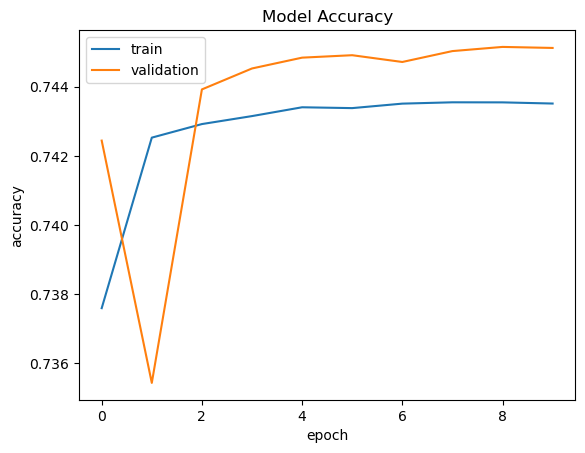

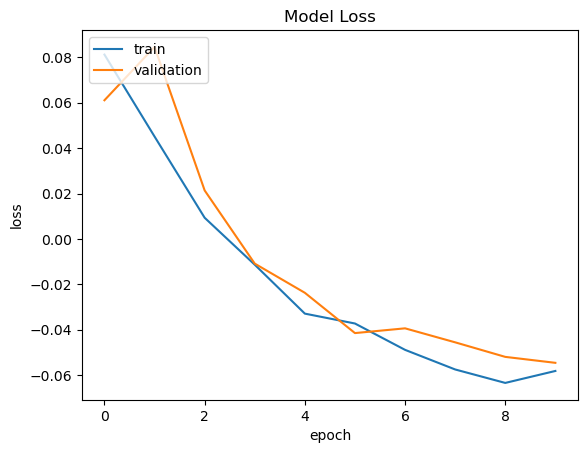

In [116]:
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## 6.2 Visualize Prediction on Test Images
Images are taken from `X_test`, which are new images that has not been used in either the previous training or validation phase.

In [33]:
preds_test = model.predict(X_test, verbose=1)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step


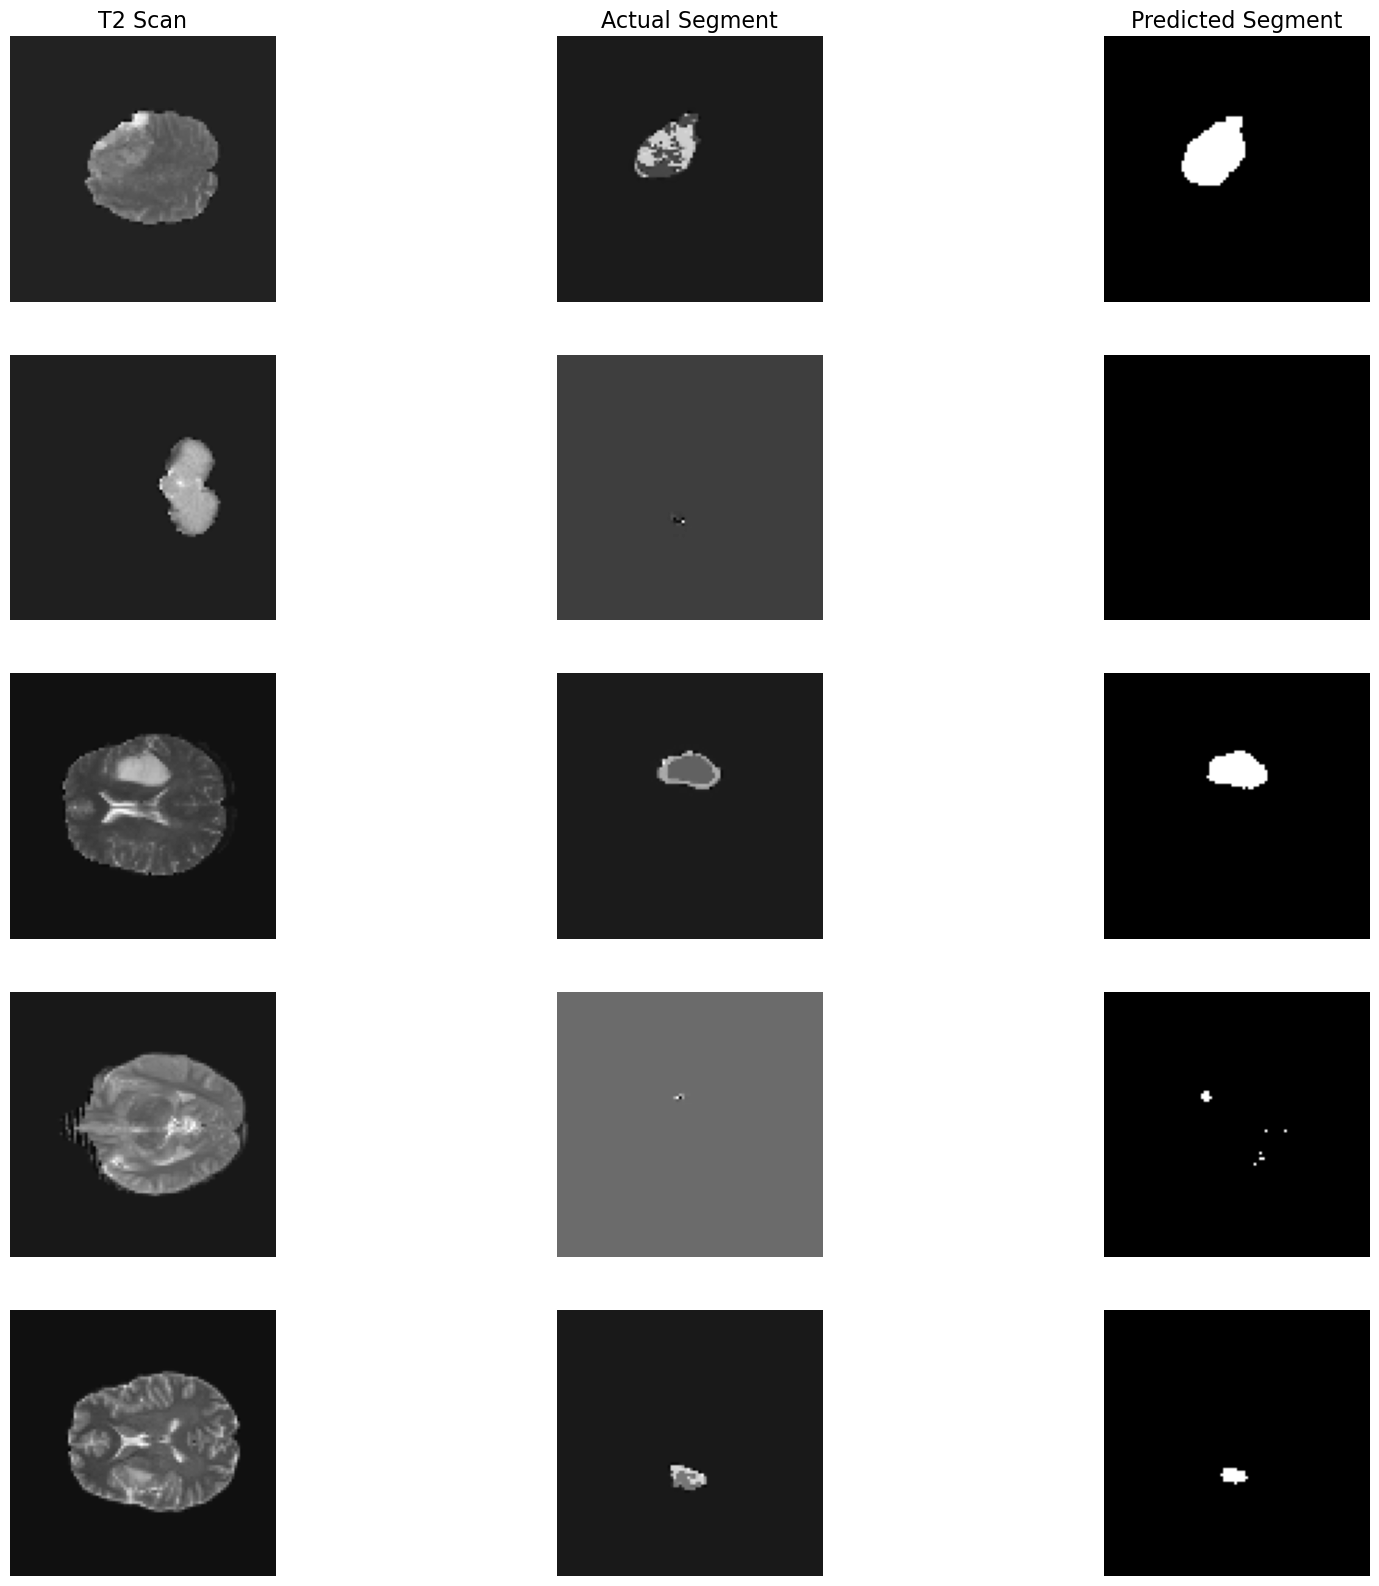

In [85]:
rand_index = np.random.randint(0, len(X_test), size=5)
fig, ax = plt.subplots(5, 3, figsize=(20, 20))

ax[0, 0].set_title('T2 Scan', fontsize=16)
ax[0, 1].set_title('Actual Segment', fontsize=16)
ax[0, 2].set_title('Predicted Segment', fontsize=16)

for i in range(5):
    ax[i,0].imshow(X_test[rand_index[i]], cmap='gray')
    ax[i,0].axis('off')
    
    ax[i,1].imshow(np.squeeze(Y_test[rand_index[i]]), cmap='gray')
    ax[i,1].axis('off')
    
    ax[i,2].imshow(np.squeeze(preds_test_t[rand_index[i]]), cmap='gray')
    ax[i,2].axis('off')